In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

['/home/hieutt/UniCon/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [2]:
from dataset import CANDatasetOld
from dataset import CANDatasetEnet as CANDataset
import torch
from torchvision import transforms
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

In [3]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda")

In [88]:
can_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_dataset = CANDataset(root_dir='../data/can-ml/2017-subaru-forester/preprocessed/size_64_10/TFRecord_w64_s32/2', window_size=32, is_train=False, transform=can_transform)
# test_dataset = CANDataset(root_dir='../data/can-ml/2017-subaru-forester/preprocessed/size_64_10_baseline/TFRecord_w64_s32/2', window_size=32, is_train=False, transform=can_transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [5]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [89]:
from networks.resnet_big import ConResNet
from networks.efficient_net import ConEfficientNet, LinearClassifier
# from networks.resnet_big import LinearClassifier

# model = ConResNet('resnet50')
# classifier = LinearClassifier(num_classes=10)

model = ConEfficientNet(embedding_dim=1792, feat_dim=128, head='mlp', pretrained=False)
classifier = LinearClassifier(input_dim=1792, num_classes=10)

In [90]:
save_path = '../save/CAN-ML_models/UniCon/UniCon_CAN-ML_efficient-net_lr_0.05_decay_0.0001_bsz_64_temp_0.07_mixup_lambda_0.5_trial_can_ml_con_enet_b4_64_cosine_warm'
ckpt_epoch = 158
# save_path = '../save/CAN-ML_models/UniCon/UniCon_CAN-ML_resnet50_lr_0.05_decay_0.0001_bsz_64_temp_0.07_mixup_lambda_0.5_trial_can_ml_uni_resnet_cosine_warm/'
# ckpt_epoch = 37
model_path = f'{save_path}/last.pth'
model_path = f'{save_path}/ckpt_epoch_{ckpt_epoch}.pth'
ckpt = torch.load(model_path, weights_only=False)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [91]:
class_model_path = f'{save_path}/ckpt_class_epoch_{ckpt_epoch}.pth'
# class_model_path = f'{save_path}/last.pth'
ckpt = torch.load(class_model_path, weights_only=False)
state_dict = ckpt['model']
classifier.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [93]:
import numpy as np
import tqdm
total_pred = np.empty(shape=(0), dtype=int)
total_label = np.empty(shape=(0), dtype=int)
total_embs = np.empty(shape=(0, 1792), dtype=float)
# total_embs = np.empty(shape=(0, 2048), dtype=float)

model = model.cuda()
classifier = classifier.cuda()
model.eval()
classifier.eval()
with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader):
        images = images.cuda(non_blocking=True)
        embs = model.encoder(images)
        outputs = classifier(embs)
        _, pred = outputs.topk(1, 1, True, True)
        pred = pred.t().cpu().numpy().squeeze(0)
        embs = embs.cpu().numpy()

        total_embs = np.concatenate((total_embs, embs), axis=0)
        total_pred = np.concatenate((total_pred, pred), axis=0)
        total_label = np.concatenate((total_label, labels), axis=0)
# After the loop, total_pred, total_label, and total_embs will have accumulated data


  0%|          | 0/410 [00:00<?, ?it/s]

100%|██████████| 410/410 [00:49<00:00,  8.30it/s]


In [10]:
from sklearn.metrics import confusion_matrix

def cal_metric(label, pred):
    cm = confusion_matrix(label, pred)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    precision[np.isnan(precision)] = 0  # Handle NaN values in precision
    
    f1 = 2 * recall * precision / (recall + precision)
    f1[np.isnan(f1)] = 0  # Handle NaN values in F1 score
    
    total_actual = np.sum(cm, axis=1)
    true_predicted = np.diag(cm)
    fnr = (total_actual - true_predicted) * 100 / total_actual
    
    return cm, {
        'fnr': np.array(fnr),
        'rec': recall,
        'pre': precision,
        'f1': f1
    }

In [11]:
def print_metrics_horizontal(metrics, class_names):
    # Determine the maximum width for class names for proper alignment
    max_name_len = max(len(name) for name in class_names) + 2  # Extra padding
    
    # Print header with class names aligned
    header = f"{'Metric':<6} | " + " | ".join([f"{name:<{max_name_len}}" for name in class_names])
    print(header)
    print("-" * (8 + len(class_names) * (max_name_len + 2)))
    
    # Print each metric's values for all classes
    for key, values in metrics.items():
        row = f"{key.upper():<6} | " + " | ".join([f"{value:<{max_name_len}.4f}" for value in values])
        print(row)

In [12]:
classes = ['Normal', 'Combined', 'DoS', 'Fuzzing', 'Gear','Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

n_classes = len(classes)

In [13]:
cm, results = cal_metric(total_label, total_pred)
print_metrics_horizontal(results, classes)

Metric | Normal       | Combined     | DoS          | Fuzzing      | Gear         | Interval     | RPM          | Speed        | Standstill   | Systematic  
----------------------------------------------------------------------------------------------------------------------------------------------------
FNR    | 0.1669       | 1.8251       | 0.4975       | 4.7244       | 8.4906       | 0.0524       | 3.7594       | 3.1315       | 1.0753       | 2.7875      
REC    | 0.9983       | 0.9817       | 0.9950       | 0.9528       | 0.9151       | 0.9995       | 0.9624       | 0.9687       | 0.9892       | 0.9721      
PRE    | 0.9958       | 0.9938       | 1.0000       | 0.9918       | 0.9417       | 0.9990       | 0.9821       | 0.9957       | 1.0000       | 0.9688      
F1     | 0.9970       | 0.9878       | 0.9975       | 0.9719       | 0.9282       | 0.9992       | 0.9722       | 0.9820       | 0.9946       | 0.9704      


In [14]:
from sklearn.metrics import classification_report


target_names = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
report = classification_report(total_label, total_pred, target_names=target_names, digits=4)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Normal     0.9958    0.9983    0.9970     20973
    Combined     0.9938    0.9817    0.9878      1315
         DoS     1.0000    0.9950    0.9975       201
       Fuzzy     0.9918    0.9528    0.9719       254
        Gear     0.9417    0.9151    0.9282       212
    Interval     0.9990    0.9995    0.9992      1909
         RPM     0.9821    0.9624    0.9722       399
       Speed     0.9957    0.9687    0.9820       479
  Standstill     1.0000    0.9892    0.9946       186
  Systematic     0.9688    0.9721    0.9704       287

    accuracy                         0.9950     26215
   macro avg     0.9869    0.9735    0.9801     26215
weighted avg     0.9950    0.9950    0.9950     26215



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def draw_confusion_matrix(cm, classes, save_dir=None):
    cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)
    mask = np.zeros_like(cm)
    np.fill_diagonal(mask, 1)
    plt.figure(figsize=(10,8))
    # sns.heatmap(cm_df, fmt='d', annot=True, cmap='YlGnBu', cbar=False, linewidths=0.5)
    sns.heatmap(cm_df, fmt='d', annot=True, cmap='YlGnBu', cbar=False, 
            linewidths=0.5, vmin=0, vmax=2500,)
    plt.xticks(rotation=45, ha='right')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    if save_dir is not None:
        plt.savefig(save_dir.format(ckpt_epoch), dpi=300, bbox_inches="tight", pad_inches=0.5)
    plt.show()

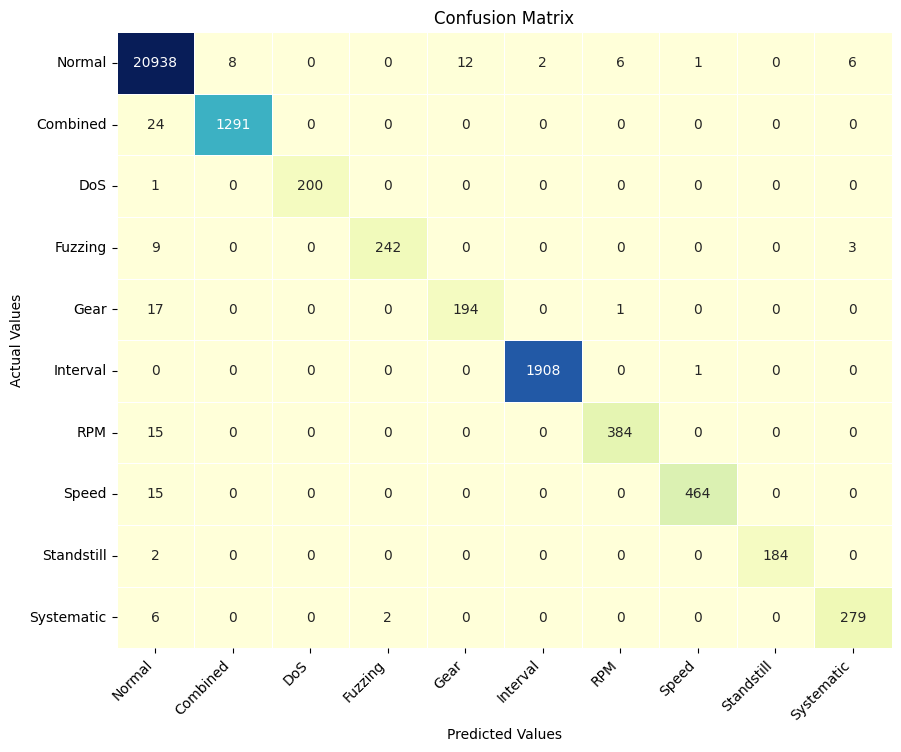

In [16]:
draw_confusion_matrix(cm, classes, save_dir='../pic/conf_matrix/confusion_matrix_unicon_resnet_can_ml_{}.png')
# draw_confusion_matrix(cm, classes)

In [17]:
# np.random.seed(100)
# indices = np.empty(shape=(0), dtype=int)
# num_samples = 1000
# for c in range(n_classes):
#     idx_c = np.where(total_label==c)[0]
#     idx_c = np.random.choice(idx_c, num_samples, replace=True)
#     indices = np.concatenate((indices, idx_c), axis=0)

np.random.seed(100)

# Chọn số lượng mẫu cho mỗi lớp (giả định tất cả đều bằng nhau)
num_samples = 1000
indices = np.empty(shape=(0), dtype=int)
for c in range(n_classes):
    idx_c = np.where(total_label == c)[0]
    if len(idx_c) == 0:
        print(f"Warning: No samples found for class {c}.")
        continue
    idx_c = np.random.choice(idx_c, num_samples, replace=True)
    indices = np.concatenate((indices, idx_c), axis=0)


In [18]:
total_embs[indices] /= 10**2
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(total_embs[indices])

In [19]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', n_jobs=-1, perplexity=40)
new_embs = tsne.fit_transform(total_embs[indices])

In [20]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None, save_dir=None):
    plt.figure(figsize=(10,10))
    for i in range(n_classes):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)
    plt.savefig(save_dir.format(ckpt_epoch), dpi=300)

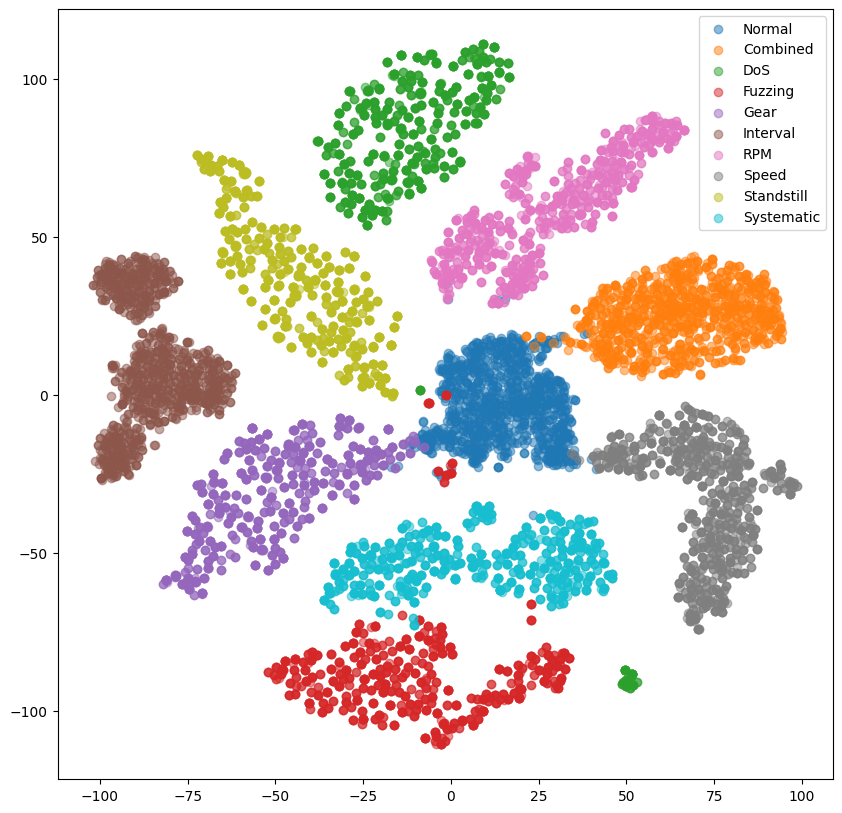

In [21]:
plot_embeddings(new_embs, total_label[indices], save_dir='../pic/tsne/tsne_unicon_resnet_can_ml_{}.png')